In [3]:
import cv2
from skimage.feature import hog
import numpy as np
import mahotas
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
def color_hist(input_image, nbins=32):
    ch1 = np.histogram(input_image[:,:,0], bins = nbins, range = (0, 256))[0] # [0] is because we need only the histogram, not bins edges
    ch2 = np.histogram(input_image[:,:,1], bins = nbins, range = (0, 256))[0]
    ch3 = np.histogram(input_image[:,:,2], bins = nbins, range = (0, 256))[0]
    return np.hstack((ch1, ch2, ch3))

In [5]:
def extract_features(input_image, nbins, orient, pix_per_cell, cell_per_block):
    output = []
    for img in input_image:
        img_ = np.asarray(Image.fromarray((img*255).astype('uint8')).convert('L'))
        features = hog(img_, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell), 
                       cells_per_block = (cell_per_block, cell_per_block), 
                       multichannel=False, transform_sqrt = True, visualize = False, feature_vector = True )
        output.append(np.hstack((cv2.resize(img*255, dsize=(16,16)).ravel(),color_hist(img*255, nbins),features)))
    return np.array(output)


In [ ]:
#labels = np.load('labels_SVM.npy')
#features = np.load('features.npy')

#X_test_ = np.load('test_features.npy')
#y_test_ = np.load('test_labels_SVM.npy')

In [7]:
X_train = np.load('train_data.npy')
y_train = np.load('train_labels.npy')
#X_test = np.load("test_data.npy")
#y_test = np.load('test_labels.npy')
X_val = np.load('val_data.npy')
y_val = np.load('val_labels.npy')

X_train = np.concatenate((X_train,X_val), axis=0)
y_train = np.concatenate((y_train,y_val), axis=0)

In [8]:
label_list = []
for label in y_train:
    label_list.append(np.argmax(label))


In [9]:
nbins, orient, pix_per_cell, cell_per_block = [64, 8, 4, 1]
features = extract_features(X_train, nbins, orient, pix_per_cell, cell_per_block)
y_train = np.array(label_list)
                  
# Fit a per-column scaler
X_scaler = StandardScaler().fit(features)
# Apply the scaler to X
scaled_X = X_scaler.transform(features)
X_train, X_val, y_train, y_val = train_test_split(scaled_X, y_train, test_size=0.2, random_state=22)

In [ ]:
print(X_train.shape)

In [ ]:
np.save('SVM_train_data',X_train)
np.save('SVM_train_labels', y_train)
np.save('SVM_val_data', X_val)
np.save('SVM_val_labels', y_val)

In [2]:
X_train = np.load('SVM_train_data.npy')
y_train = np.load('SVM_train_labels.npy')
X_val = np.load('SVM_val_data.npy')
y_val = np.load('SVM_val_labels.npy')

In [ ]:
# C = 0.2 optimal (not much difference)
reg = np.arange(0.1,2,0.1)
test_acc = []
for c in reg:
    svc = LinearSVC(dual=True, C=c, max_iter=10)
    svc.fit(X_train, y_train)
    test_acc.append(svc.score(X_val, y_val))
    print(test_acc)

In [10]:
svc = LinearSVC(dual=True, C=0.2, max_iter=20)
svc.fit(X_train, y_train)
print(svc.score(X_val, y_val))


0.970691382765531


/home/darius/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [11]:
X_test = np.load("test_data.npy")
y_test = np.load('test_labels.npy')

In [12]:

label_list = []
for label in y_test:
    label_list.append(np.argmax(label))
y_test = np.array(label_list)

nbins, orient, pix_per_cell, cell_per_block = [64, 8, 4, 1]
features = extract_features(X_test, nbins, orient, pix_per_cell, cell_per_block)
                   
# Fit a per-column scaler
X_scaler = StandardScaler().fit(features)
# Apply the scaler to X
scaled_X_test = X_scaler.transform(features)
#X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

In [13]:
class_features = []
class_labels = []
for i in range(0,43):
    class_features.append([])
    class_labels.append([])

for i, label in enumerate(y_test):
    class_labels[int(label)].append(label)
    class_features[int(label)].append(scaled_X_test[i])
    

In [14]:
results = []
for i, c in enumerate(class_features):
    score = svc.score(np.array(c), class_labels[i])
    #print('Class: ', i)
    #print('Test loss:', score[0]) 
    #print('Test accuracy:', score[1])
    results.append(score)

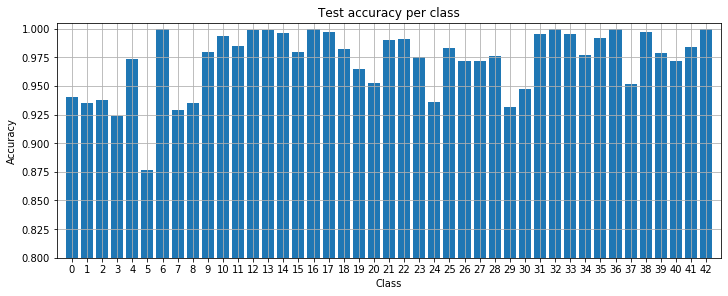

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), constrained_layout=True)

width = 0.8  # the width of the bars
axs.grid(True)
barlist = axs.bar(np.arange(0,43),results, width)
#for i, bar in enumerate(barlist):
    #if results[i] < 0.98:
        #bar.set_color('tab:red')

axs.set_xticks(np.arange(0,43))#, rotation='vertical')
axs.set_xlim(xmax=43,xmin=-1)
axs.set_ylim(ymax=1.005,ymin=0.8)
#axs.set_yticks(np.arange(0,750,75))

axs.set_xlabel('Class')
axs.set_ylabel('Accuracy')
axs.set_title('Test accuracy per class')
#plt.savefig('Class_accuracy_(freshtrained_model_trained_on_500_aug_images_per_class+orig_train).png', dpi=500)
plt.savefig('Class_accuracy_SVM.png', dpi=500)

In [16]:
svc.score(scaled_X_test, y_test)

0.9688836702172272

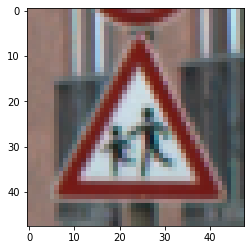

In [46]:
from skimage.feature import hog
nbins, orient, pix_per_cell, cell_per_block = [64, 8, 4, 1]
plt.imshow(X_test[32])

features, image = hog(X_test[32], orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell), 
                       cells_per_block = (cell_per_block, cell_per_block), 
                       multichannel=True, transform_sqrt = True, visualize = True, feature_vector = True )
#plt.imshow(image, cmap='gray')

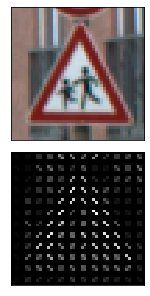

In [51]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(2, 4), constrained_layout=True)

axs = axs.ravel()

#plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

axs[0].imshow(X_test[32])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(image, cmap='gray')
axs[1].set_xticks([])
axs[1].set_yticks([])



plt.savefig('hog_feature.png', dpi=500)
plt.show()

In [18]:
ch1 = np.histogram(X_test[32][:,:,0]*255, bins = nbins, range = (0, 255))[0]
print(ch1[0])


0


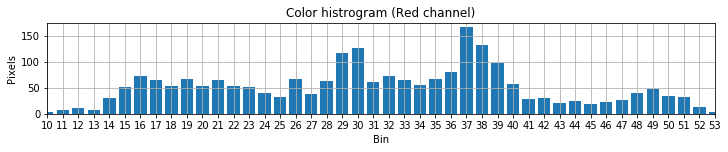

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 2), constrained_layout=True)

width = 0.8  # the width of the bars
axs.grid(True)
barlist = axs.bar(np.arange(0,64)+1,ch1, width)
#for i, bar in enumerate(barlist):
    #if results[i] < 0.98:
        #bar.set_color('tab:red')

axs.set_xticks(np.arange(0,64)+1)#, rotation='vertical')
axs.set_xlim(xmax=53,xmin=10)
#axs.set_ylim(ymax=1.005,ymin=0.8)
#axs.set_yticks(np.arange(0,750,75))

axs.set_xlabel('Bin')
axs.set_ylabel('Pixels')

axs.set_title('Color histrogram (Red channel)')
#plt.savefig('Class_accuracy_(freshtrained_model_trained_on_500_aug_images_per_class+orig_train).png', dpi=500)
plt.savefig('color_hist_ch1.png', dpi=500)

In [ ]:
img_ = np.asarray(Image.fromarray(features[2]).convert('L'))
features_ = hog(img_, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell), 
               cells_per_block = (cell_per_block, cell_per_block), 
               multichannel=False, transform_sqrt = True, visualize = False, feature_vector = True )
print(features_.shape)

In [ ]:
svc = SVC(gamma = 'auto', cache_size = 2048)
svc.fit(X_train, y_train)
test_acc = svc.score(X_test, y_test)

In [ ]:
space  = [(8, 32),                  # Number of bins for color histogram
          (4, 8),                  # HOG number of orientations
          (4, 8),                  # HOG pixels per cell
          (1, 2)]                   # HOG cells per block
i = 0

def obj(params):
    global i
    nbins, orient, pix_per_cell, cell_per_block = params
    # Use only every 10th images to speed things up.
    features_ = extract_features(features[::20,:,:,:], nbins, orient, pix_per_cell, cell_per_block)
    y = labels[::20]
    X = features_                    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    test_acc = svc.score(X_test, y_test)
    print (i, params, test_acc)
    i += 1
    return 1.0 - test_acc
    
res = gp_minimize(obj, space, n_calls = 20, random_state = 22)
print("Best score=%.4f" % res.fun)